In [1]:
! pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
  0% 0.00/80.9M [00:00<?, ?B/s]
100% 80.9M/80.9M [00:00<00:00, 856MB/s]


In [5]:
from zipfile import ZipFile

In [6]:
dataset = '/content/sentiment140.zip'
with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [7]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [10]:
twitter_data=pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='latin-1')

In [11]:
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [12]:
twitter_data.tail()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [ ]:
twitter_data.shape

(1599999, 6)

In [13]:
column_names=['target','id','date','flag','user','text']
twitter_data=pd.read_csv('/content/training.1600000.processed.noemoticon.csv',names=column_names,encoding='latin-1')

In [14]:
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [15]:
twitter_data.isnull().sum()

,0
target,0
id,0
date,0
flag,0
user,0
text,0


In [16]:
twitter_data['target'].value_counts()

,count
target,
0,800000
4,800000


# Stemming

In [17]:
twitter_data.replace({'target':{4:1}}, inplace=True)

In [18]:
twitter_data['target'].value_counts()

,count
target,
0,800000
1,800000


In [19]:
def stemming(content):
  stemmed_content=re.sub('[^a-zA-Z]',' ',content)
  stemmed_content=stemmed_content.lower()
  stemmed_content=stemmed_content.split()
  stemmed_content=[PorterStemmer().stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content=' '.join(stemmed_content)
  return stemmed_content

In [22]:
twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming)

In [23]:
twitter_data.head()

,target,id,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [24]:
print(twitter_data['stemmed_content'])

0          switchfoot http twitpic com zl awww bummer sho...
1          upset updat facebook text might cri result sch...
2          kenichan dive mani time ball manag save rest g...
3                            whole bodi feel itchi like fire
4                              nationwideclass behav mad see
                                 ...                        
1599995                           woke school best feel ever
1599996    thewdb com cool hear old walt interview http b...
1599997                         readi mojo makeov ask detail
1599998    happi th birthday boo alll time tupac amaru sh...
1599999    happi charitytuesday thenspcc sparkschar speak...
Name: stemmed_content, Length: 1600000, dtype: object


In [25]:
print(twitter_data['target'])

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


In [30]:
X = twitter_data['stemmed_content'].values
Y = twitter_data['target'].values

In [31]:
print(X)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']


In [32]:
print(Y)

[0 0 0 ... 1 1 1]


In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [34]:

print(X.shape, X_train.shape, X_test.shape)

(1600000,) (1280000,) (320000,)


In [35]:
print(X_train)

['watch saw iv drink lil wine' 'hatermagazin'
 'even though favourit drink think vodka coke wipe mind time think im gonna find new drink'
 ... 'eager monday afternoon'
 'hope everyon mother great day wait hear guy store tomorrow'
 'love wake folger bad voic deeper']


In [36]:
print(X_test)

['mmangen fine much time chat twitter hubbi back summer amp tend domin free time'
 'ah may show w ruth kim amp geoffrey sanhueza'
 'ishatara mayb bay area thang dammit' ...
 'destini nevertheless hooray member wonder safe trip' 'feel well'
 'supersandro thank']


# Model Evaluation

In [37]:
vectorizer = TfidfVectorizer()

In [38]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [39]:
print(X_train)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9453092 stored elements and shape (1280000, 461488)>
  Coords	Values
  (0, 436713)	0.27259876264838384
  (0, 354543)	0.3588091611460021
  (0, 185193)	0.5277679060576009
  (0, 109306)	0.3753708587402299
  (0, 235045)	0.41996827700291095
  (0, 443066)	0.4484755317023172
  (1, 160636)	1.0
  (2, 109306)	0.4591176413728317
  (2, 124484)	0.1892155960801415
  (2, 407301)	0.18709338684973031
  (2, 129411)	0.29074192727957143
  (2, 406399)	0.32105459490875526
  (2, 433560)	0.3296595898028565
  (2, 77929)	0.31284080750346344
  (2, 443430)	0.3348599670252845
  (2, 266729)	0.24123230668976975
  (2, 409143)	0.15169282335109835
  (2, 178061)	0.1619010109445149
  (2, 150715)	0.18803850583207948
  (2, 132311)	0.2028971570399794
  (2, 288470)	0.16786949597862733
  (3, 406399)	0.29029991238662284
  (3, 158711)	0.4456939372299574
  (3, 151770)	0.278559647704793
  (3, 56476)	0.5200465453608686
  :	:
  (1279996, 318303)	0.21254698865277744
  (12

In [40]:
print(X_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2289192 stored elements and shape (320000, 461488)>
  Coords	Values
  (0, 15110)	0.1719352837797837
  (0, 31168)	0.1624772418052177
  (0, 67828)	0.26800375270827315
  (0, 106069)	0.36555450010904555
  (0, 132364)	0.255254889555786
  (0, 138164)	0.23688292264071406
  (0, 171378)	0.2805816206356074
  (0, 271016)	0.45356623916588285
  (0, 279082)	0.17825180109103442
  (0, 388348)	0.2198507607206174
  (0, 398906)	0.34910438732642673
  (0, 409143)	0.3143047059807971
  (0, 420984)	0.17915624523539805
  (1, 6463)	0.30733520460524466
  (1, 15110)	0.211037449588008
  (1, 145393)	0.575262969264869
  (1, 217562)	0.40288153995289894
  (1, 256777)	0.28751585696559306
  (1, 348135)	0.4739279595416274
  (1, 366203)	0.24595562404108307
  (2, 22532)	0.3532582957477176
  (2, 34401)	0.37916255084357414
  (2, 89448)	0.36340369428387626
  (2, 183312)	0.5892069252021465
  (2, 256834)	0.2564939661498776
  :	:
  (319994, 443794)	0.2782185641032538


Saving the trained model

In [41]:
model = LogisticRegression(class_weight='balanced')

Using the saved model for future predictions

In [42]:

model.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced')

#Accuracy Score

In [43]:
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [44]:
print('Accuracy score on the training data:', training_data_accuracy)

Accuracy score on the training data: 0.79871953125


In [45]:
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [46]:
print('Accuracy score on the training data:', test_data_accuracy)

Accuracy score on the training data: 0.77668125


In [47]:

def predict_sentiment(tweet):

    stemmed_tweet = re.sub('[^a-zA-Z]', ' ', tweet)
    stemmed_tweet = stemmed_tweet.lower()
    stemmed_tweet = stemmed_tweet.split()
    stemmed_tweet = [PorterStemmer().stem(word) for word in stemmed_tweet if not word in stopwords.words('english')]
    stemmed_tweet = ' '.join(stemmed_tweet)


    tweet_vector = vectorizer.transform([stemmed_tweet])


    prediction = model.predict(tweet_vector)

    return prediction[0]

tweet = input("Enter a tweet: ")
result = predict_sentiment(tweet)
print(result)

Enter a tweet: I love you
1


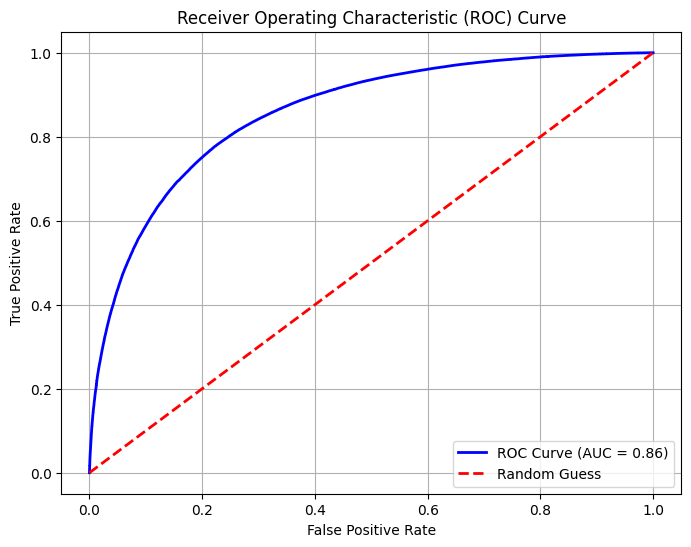

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(Y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Ploting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(Y_test, X_test_prediction))

print("Confusion Matrix:")
print(confusion_matrix(Y_test, X_test_prediction))

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    160000
           1       0.77      0.80      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000

Confusion Matrix:
[[121246  38754]
 [ 32708 127292]]
